# The Joy of Neural Painting (2/4)

[Neural Painters](https://arxiv.org/abs/1904.08410) [1] are a class of models that can be seen as a fully differentiable simulation of a particular non-differentiable painting program, in other words, the machine "paints" by successively generating brushstrokes (i.e., actions that defines a brushstrokes) and applying them on a canvas, as an artist would do.

---

[1] *Neural Painters: A Learned Differentiable Constraint for Generating Brushstroke Paintings*. Reiichiro Nakano. arXiv preprint [arXiv:1904.08410](https://arxiv.org/abs/1904.08410), 2019.

# Training the Critic as a Binary Classifier (Non-Adversarially)

The goal in this stage is to train the `Critic` on a a binary classification task: to discriminate between true and generated (fake) brushstrokes. 

We will use the `Generator` trained previously to generate strokes. The `Generator`'s parameters will be frozen, that is, they will not be updated in this stage.

<center><img src="https://raw.githubusercontent.com/libreai/neural-painter-x/master/images/neural_painter_critic_non_adversarial.jpg" width="45%"/></center>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as VF
import torch.optim as optim
import fastai
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import PIL
import os

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from glob import glob
from torchvision import models
from pathlib import Path
from IPython.display import display, clear_output

# from fastai.vision import *
from fastai.torch_core import requires_grad, children
from fastai.vision.gan import basic_generator, gan_critic
from fastai.callbacks import hook_outputs

print('torch.__version__', torch.__version__)


torch.__version__ 1.1.0


# Dataset

For the purposes of this excercise we will use a collection of 100K brushstrokes, that is a single `episodes` file from the full `neural-painters` dataset available in Kaggle: https://www.kaggle.com/reiinakano/mypaint_brushstrokes

We have made available the file using Google Drive: [episodes_42.npz](https://drive.google.com/a/libreai.com/uc?id=1Fl9K6XbDr_5lOb0J-lzjPX9SoJ9M7j1x&export=download). Given its size (196M) `wget` or `curl` will fail because of the security warning from Google Drive, we will therefore go with [gdwon](https://pypi.org/project/gdown/) to download it.

In [0]:
!pip install gdown

In [0]:
# create a folder called `data` and donwload the dataset there
!mkdir data; cd data; gdown https://drive.google.com/uc?id=1Fl9K6XbDr_5lOb0J-lzjPX9SoJ9M7j1x

Downloading...
From: https://drive.google.com/uc?id=1Fl9K6XbDr_5lOb0J-lzjPX9SoJ9M7j1x
To: /content/data/episodes_42.npz
206MB [00:01, 104MB/s]


In [0]:
data_fname = 'episodes_42.npz'
loaded = np.load('data/' + data_fname)

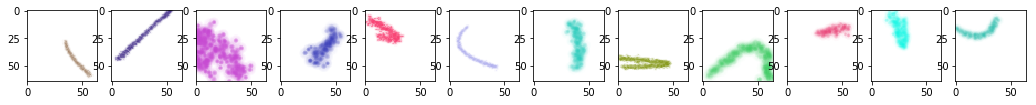

In [0]:
w=800
h=600

fig=plt.figure(figsize=(30, 10))
cols = 12

smaller_arr = loaded['strokes'][:cols]

for col in range(cols):
    img = smaller_arr[col][:, :, :3]
    fig.add_subplot(1, 20, col+1)
    plt.grid(False)
    plt.imshow(img)
plt.show()

In [0]:
loaded['actions'][:cols]

array([[0.330522, 0.249296, 0.638134, 0.656268, ..., 0.38073 , 0.896127, 0.924754, 0.466711],
       [0.72314 , 0.260811, 0.776887, 0.059226, ..., 0.559846, 0.741848, 0.114233, 0.203668],
       [0.992721, 0.830709, 0.019449, 0.30396 , ..., 0.821641, 0.674657, 0.922126, 0.893378],
       [0.174172, 0.807182, 0.734837, 0.432679, ..., 0.718031, 0.459332, 0.69727 , 0.848882],
       ...,
       [0.234808, 0.834783, 0.7658  , 0.520075, ..., 0.341833, 0.937458, 0.986008, 0.497608],
       [0.295077, 0.680203, 0.709675, 0.272433, ..., 0.458307, 0.830108, 0.251563, 0.731567],
       [0.227581, 0.703463, 0.452308, 0.504263, ..., 0.88884 , 0.30347 , 0.054811, 0.541374],
       [0.41137 , 0.667527, 0.380177, 0.360587, ..., 0.664123, 0.001316, 0.249934, 0.20228 ]])

# Train a Critic as Binary Classifier: True or Fake images with Generator frozen

In [0]:
# a helper class to encapsulate some parameters
class Params():
    def __init__(self):
        super(Params)

In [0]:
params = Params()

params.condition_dim = 12
params.noise_dim = 0
params.image_size = 64
params.channels = 3
params.batch_size = 512
params.lr = 1e-3
params.train_epochs = 10
params.fc_dim = int(params.image_size * params.image_size)

In [0]:
critic = gan_critic(nf=64)
critic.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (1): Dropout2d(p=0.075)
  (2): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
      )
      (2): MergeLayer()
    )
  )
  (3): Dropout2d(p=0.15)
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): SelfAttention(
      (query): Conv1d(256, 32, kernel_size=(1,), stride=(1,), bias=False)
      (key): Conv1d(256, 32, kernel_size=(1,), stride=(1,), bias=False)
      (value): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False

## Load the Pre-Trained Generator

The `Generator` is defined as a [`Linear Layer`](https://pytorch.org/docs/stable/nn.html#linear) followed by a [`Deep Convolutional Neural Network`](https://docs.fast.ai/vision.gan.html#basic_generator)

In [0]:
class GeneratorX(nn.Module):

    def __init__(self, condition_dim, fc_dim, in_size, n_channels, n_extra_layers):
        super(GeneratorX, self).__init__()
        self.fc = nn.Linear(condition_dim, fc_dim)
        self.generator = basic_generator(in_size=in_size, n_channels=n_channels, n_extra_layers=n_extra_layers, noise_sz=fc_dim)

    def forward(self, x):
        x = self.fc(x)
        x = self.generator(x.view(x.size(0), x.size(1), 1, 1))
        return x



In [0]:
generator = GeneratorX(condition_dim=params.condition_dim,
                fc_dim=params.fc_dim,
                in_size=params.image_size,
                n_channels=params.channels,
                n_extra_layers=1
               )

generator

GeneratorX(
  (fc): Linear(in_features=12, out_features=4096, bias=True)
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, 

Here you have to load the pre-trained `Generator` from the previous phase. 

In [0]:
!ls models

neural_painter_x_non_adversarial_generator_param.pth


In [0]:
# Just in case you do not have your `Generator` at hand, you can uncomment the following lines 
# to download one we trained:
#!mkdir models
#!cd models; gdown https://drive.google.com/uc?id=1knOYFm-PBk0ovwPoVjV5ivc6-ts-8eHG

Downloading...
From: https://drive.google.com/uc?id=1knOYFm-PBk0ovwPoVjV5ivc6-ts-8eHG
To: /content/models/neural_painter_x_non_adversarial_generator_param.pth
146MB [00:02, 58.5MB/s]


No let's load the `Generator` and freeze its parameters:

In [0]:
generator.load_state_dict(torch.load("models/neural_painter_x_non_adversarial_generator_param.pth"))
# freeze the generator parameters
for param in generator.parameters():
    generator.requires_grad = False
generator.cuda().eval();

---

## Learn the Critic

In [0]:
critic_optimizer = optim.Adam(critic.parameters(), lr=params.lr, betas=(0.5, 0.999))

In [0]:
critic_loss = torch.nn.functional.binary_cross_entropy

In [0]:
strokes_tfms = transforms.Compose([transforms.Lambda(lambda x: x.float()),
                                   transforms.Lambda(lambda x: x.div_(255))
                                  ])


In [0]:
strokes = loaded['strokes']
conditions = loaded['actions']

strokes = torch.stack([torch.from_numpy(s).permute(2, 0, 1) for s in strokes])
conditions = torch.stack([torch.from_numpy(c).float() for c in conditions])

dataset = TensorDataset(strokes, conditions)
dataloader = DataLoader(dataset, batch_size=params.batch_size, shuffle=False)


training start!
epoch 1/10  1/196 complete!
loss: 0.6962828636169434
real brushstroke
critic pred: 0.5126596689224243 (true=1)


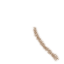

generated brushstroke
critic pred:  0.48180586099624634 (true=0)


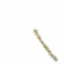

---
epoch 1/10  26/196 complete!
loss: 0.8153194189071655
real brushstroke
critic pred: 0.49810510873794556 (true=1)


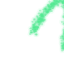

generated brushstroke
critic pred:  0.4999631643295288 (true=0)


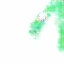

---
epoch 1/10  51/196 complete!
loss: 0.7553265690803528
real brushstroke
critic pred: 0.49854370951652527 (true=1)


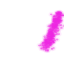

generated brushstroke
critic pred:  0.5115702748298645 (true=0)


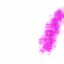

---
epoch 1/10  76/196 complete!
loss: 0.734701931476593
real brushstroke
critic pred: 0.5076099038124084 (true=1)


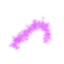

generated brushstroke
critic pred:  0.5149884223937988 (true=0)


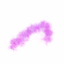

---
epoch 1/10  101/196 complete!
loss: 0.7240874767303467
real brushstroke
critic pred: 0.5017966628074646 (true=1)


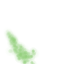

generated brushstroke
critic pred:  0.49755799770355225 (true=0)


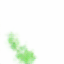

---
epoch 1/10  126/196 complete!
loss: 0.7172678709030151
real brushstroke
critic pred: 0.4834950268268585 (true=1)


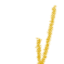

generated brushstroke
critic pred:  0.48845216631889343 (true=0)


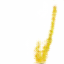

---
epoch 1/10  151/196 complete!
loss: 0.7123332023620605
real brushstroke
critic pred: 0.3240881860256195 (true=1)


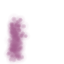

generated brushstroke
critic pred:  0.34481197595596313 (true=0)


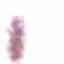

---
epoch 1/10  176/196 complete!
loss: 0.7095242142677307
real brushstroke
critic pred: 0.47843196988105774 (true=1)


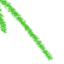

generated brushstroke
critic pred:  0.4684875011444092 (true=0)


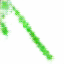

---
epoch 2/10  1/196 complete!
loss: 0.7075392603874207
real brushstroke
critic pred: 0.5218212604522705 (true=1)


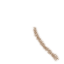

generated brushstroke
critic pred:  0.51496422290802 (true=0)


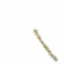

---
epoch 2/10  26/196 complete!
loss: 0.7054066061973572
real brushstroke
critic pred: 0.5124308466911316 (true=1)


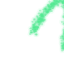

generated brushstroke
critic pred:  0.4977920353412628 (true=0)


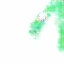

---
epoch 2/10  51/196 complete!
loss: 0.7027310132980347
real brushstroke
critic pred: 0.5253121852874756 (true=1)


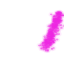

generated brushstroke
critic pred:  0.5050175786018372 (true=0)


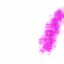

---
epoch 2/10  76/196 complete!
loss: 0.6991157531738281
real brushstroke
critic pred: 0.569010853767395 (true=1)


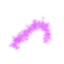

generated brushstroke
critic pred:  0.45006343722343445 (true=0)


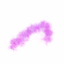

---
epoch 2/10  101/196 complete!
loss: 0.6925723552703857
real brushstroke
critic pred: 0.6129541993141174 (true=1)


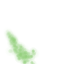

generated brushstroke
critic pred:  0.4533933103084564 (true=0)


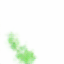

---
epoch 2/10  126/196 complete!
loss: 0.6813766956329346
real brushstroke
critic pred: 0.6121938228607178 (true=1)


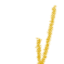

generated brushstroke
critic pred:  0.5401873588562012 (true=0)


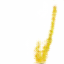

---
epoch 2/10  151/196 complete!
loss: 0.6696082353591919
real brushstroke
critic pred: 0.5920716524124146 (true=1)


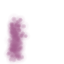

generated brushstroke
critic pred:  0.2882345914840698 (true=0)


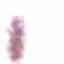

---
epoch 2/10  176/196 complete!
loss: 0.6571784615516663
real brushstroke
critic pred: 0.8574322462081909 (true=1)


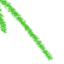

generated brushstroke
critic pred:  0.15775372087955475 (true=0)


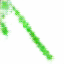

---
epoch 3/10  1/196 complete!
loss: 0.6467679738998413
real brushstroke
critic pred: 0.5629587173461914 (true=1)


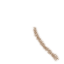

generated brushstroke
critic pred:  0.4038486182689667 (true=0)


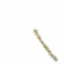

---
epoch 3/10  26/196 complete!
loss: 0.6337558627128601
real brushstroke
critic pred: 0.9693595767021179 (true=1)


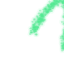

generated brushstroke
critic pred:  0.03380151093006134 (true=0)


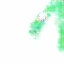

---
epoch 3/10  51/196 complete!
loss: 0.6309239268302917
real brushstroke
critic pred: 0.7711394429206848 (true=1)


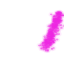

generated brushstroke
critic pred:  0.5396195650100708 (true=0)


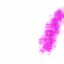

---
epoch 3/10  76/196 complete!
loss: 0.6245608329772949
real brushstroke
critic pred: 0.8094795942306519 (true=1)


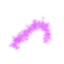

generated brushstroke
critic pred:  0.31962522864341736 (true=0)


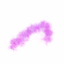

---
epoch 3/10  101/196 complete!
loss: 0.6147176623344421
real brushstroke
critic pred: 0.5136697888374329 (true=1)


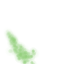

generated brushstroke
critic pred:  0.03515087068080902 (true=0)


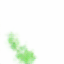

---
epoch 3/10  126/196 complete!
loss: 0.6046261787414551
real brushstroke
critic pred: 0.6189095973968506 (true=1)


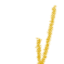

generated brushstroke
critic pred:  0.38767707347869873 (true=0)


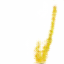

---
epoch 3/10  151/196 complete!
loss: 0.5945910215377808
real brushstroke
critic pred: 0.3685353100299835 (true=1)


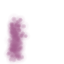

generated brushstroke
critic pred:  0.09207552671432495 (true=0)


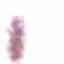

---
epoch 3/10  176/196 complete!
loss: 0.5848988890647888
real brushstroke
critic pred: 0.9073199033737183 (true=1)


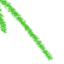

generated brushstroke
critic pred:  0.00665645906701684 (true=0)


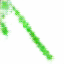

---
epoch 4/10  1/196 complete!
loss: 0.5761089324951172
real brushstroke
critic pred: 0.531646192073822 (true=1)


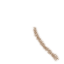

generated brushstroke
critic pred:  0.21634581685066223 (true=0)


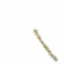

---
epoch 4/10  26/196 complete!
loss: 0.5662075281143188
real brushstroke
critic pred: 0.8044375777244568 (true=1)


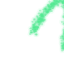

generated brushstroke
critic pred:  0.011049200780689716 (true=0)


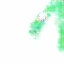

---
epoch 4/10  51/196 complete!
loss: 0.5564059019088745
real brushstroke
critic pred: 0.977946937084198 (true=1)


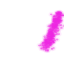

generated brushstroke
critic pred:  0.028557997196912766 (true=0)


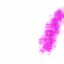

---
epoch 4/10  76/196 complete!
loss: 0.546491801738739
real brushstroke
critic pred: 0.9718513488769531 (true=1)


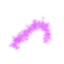

generated brushstroke
critic pred:  0.03767259791493416 (true=0)


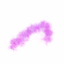

---
epoch 4/10  101/196 complete!
loss: 0.5374834537506104
real brushstroke
critic pred: 0.9125989675521851 (true=1)


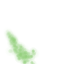

generated brushstroke
critic pred:  0.0011644696351140738 (true=0)


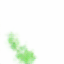

---
epoch 4/10  126/196 complete!
loss: 0.5293983221054077
real brushstroke
critic pred: 0.9551047682762146 (true=1)


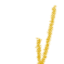

generated brushstroke
critic pred:  0.05333816260099411 (true=0)


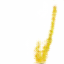

---
epoch 4/10  151/196 complete!
loss: 0.5236925482749939
real brushstroke
critic pred: 0.879093587398529 (true=1)


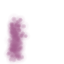

generated brushstroke
critic pred:  0.16307072341442108 (true=0)


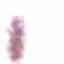

---
epoch 4/10  176/196 complete!
loss: 0.5157723426818848
real brushstroke
critic pred: 0.9686755537986755 (true=1)


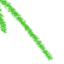

generated brushstroke
critic pred:  0.012059117667376995 (true=0)


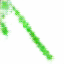

---
epoch 5/10  1/196 complete!
loss: 0.509745180606842
real brushstroke
critic pred: 0.6093015670776367 (true=1)


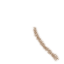

generated brushstroke
critic pred:  0.1544610857963562 (true=0)


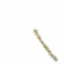

---
epoch 5/10  26/196 complete!
loss: 0.5017688274383545
real brushstroke
critic pred: 0.8038379549980164 (true=1)


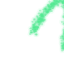

generated brushstroke
critic pred:  0.0008272139821201563 (true=0)


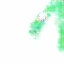

---
epoch 5/10  51/196 complete!
loss: 0.4946867525577545
real brushstroke
critic pred: 0.998330295085907 (true=1)


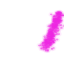

generated brushstroke
critic pred:  0.007564988452941179 (true=0)


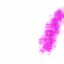

---
epoch 5/10  76/196 complete!
loss: 0.48655053973197937
real brushstroke
critic pred: 0.9241263270378113 (true=1)


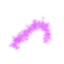

generated brushstroke
critic pred:  0.04153022542595863 (true=0)


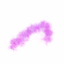

---
epoch 5/10  101/196 complete!
loss: 0.4788190722465515
real brushstroke
critic pred: 0.9562674164772034 (true=1)


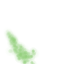

generated brushstroke
critic pred:  0.0016771354712545872 (true=0)


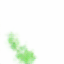

---
epoch 5/10  126/196 complete!
loss: 0.47085481882095337
real brushstroke
critic pred: 0.8728865385055542 (true=1)


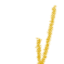

generated brushstroke
critic pred:  0.07427706569433212 (true=0)


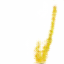

---
epoch 5/10  151/196 complete!
loss: 0.46683889627456665
real brushstroke
critic pred: 0.8194025158882141 (true=1)


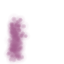

generated brushstroke
critic pred:  0.025685761123895645 (true=0)


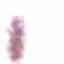

---
epoch 5/10  176/196 complete!
loss: 0.46075916290283203
real brushstroke
critic pred: 0.9999955892562866 (true=1)


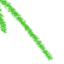

generated brushstroke
critic pred:  0.004413806367665529 (true=0)


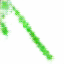

---
epoch 6/10  1/196 complete!
loss: 0.45509105920791626
real brushstroke
critic pred: 0.7761417627334595 (true=1)


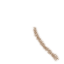

generated brushstroke
critic pred:  0.2154402732849121 (true=0)


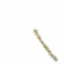

---
epoch 6/10  26/196 complete!
loss: 0.44811585545539856
real brushstroke
critic pred: 0.9886926412582397 (true=1)


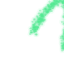

generated brushstroke
critic pred:  0.0007065506651997566 (true=0)


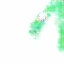

---
epoch 6/10  51/196 complete!
loss: 0.4422338306903839
real brushstroke
critic pred: 0.9990754127502441 (true=1)


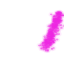

generated brushstroke
critic pred:  0.005001982674002647 (true=0)


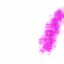

---
epoch 6/10  76/196 complete!
loss: 0.43646112084388733
real brushstroke
critic pred: 0.5614520907402039 (true=1)


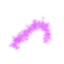

generated brushstroke
critic pred:  0.15585601329803467 (true=0)


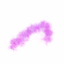

---
epoch 6/10  101/196 complete!
loss: 0.4318084418773651
real brushstroke
critic pred: 0.998731791973114 (true=1)


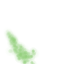

generated brushstroke
critic pred:  6.69055589241907e-05 (true=0)


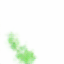

---
epoch 6/10  126/196 complete!
loss: 0.4259994924068451
real brushstroke
critic pred: 0.9592962265014648 (true=1)


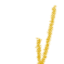

generated brushstroke
critic pred:  0.15847279131412506 (true=0)


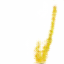

---
epoch 6/10  151/196 complete!
loss: 0.4204954504966736
real brushstroke
critic pred: 0.9740515351295471 (true=1)


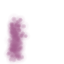

generated brushstroke
critic pred:  0.002217397093772888 (true=0)


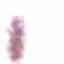

---
epoch 6/10  176/196 complete!
loss: 0.4149918556213379
real brushstroke
critic pred: 0.9999994039535522 (true=1)


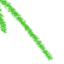

generated brushstroke
critic pred:  8.513839020451996e-06 (true=0)


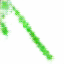

---
epoch 7/10  1/196 complete!
loss: 0.41063058376312256
real brushstroke
critic pred: 0.5267544984817505 (true=1)


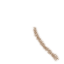

generated brushstroke
critic pred:  0.3010171353816986 (true=0)


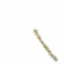

---
epoch 7/10  26/196 complete!
loss: 0.4053158760070801
real brushstroke
critic pred: 0.9854044318199158 (true=1)


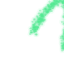

generated brushstroke
critic pred:  0.00043560564517974854 (true=0)


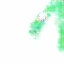

---
epoch 7/10  51/196 complete!
loss: 0.4053359031677246
real brushstroke
critic pred: 0.5848846435546875 (true=1)


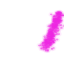

generated brushstroke
critic pred:  0.26443666219711304 (true=0)


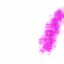

---
epoch 7/10  76/196 complete!
loss: 0.4043995440006256
real brushstroke
critic pred: 0.9106479287147522 (true=1)


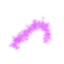

generated brushstroke
critic pred:  0.2181321531534195 (true=0)


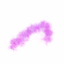

---
epoch 7/10  101/196 complete!
loss: 0.40266910195350647
real brushstroke
critic pred: 0.9818426370620728 (true=1)


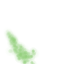

generated brushstroke
critic pred:  0.0006844589952379465 (true=0)


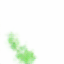

---
epoch 7/10  126/196 complete!
loss: 0.39887917041778564
real brushstroke
critic pred: 0.9390237331390381 (true=1)


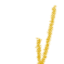

generated brushstroke
critic pred:  0.24437418580055237 (true=0)


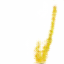

---
epoch 7/10  151/196 complete!
loss: 0.3968738913536072
real brushstroke
critic pred: 0.9913405776023865 (true=1)


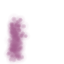

generated brushstroke
critic pred:  0.014661064371466637 (true=0)


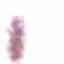

---
epoch 7/10  176/196 complete!
loss: 0.39316031336784363
real brushstroke
critic pred: 0.9991747736930847 (true=1)


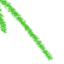

generated brushstroke
critic pred:  0.00023242409224621952 (true=0)


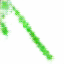

---
epoch 8/10  1/196 complete!
loss: 0.38976189494132996
real brushstroke
critic pred: 0.8279945850372314 (true=1)


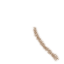

generated brushstroke
critic pred:  0.07593830674886703 (true=0)


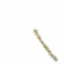

---
epoch 8/10  26/196 complete!
loss: 0.3856094777584076
real brushstroke
critic pred: 0.9056507349014282 (true=1)


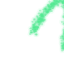

generated brushstroke
critic pred:  0.0014860010705888271 (true=0)


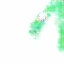

---
epoch 8/10  51/196 complete!
loss: 0.38138478994369507
real brushstroke
critic pred: 0.9999934434890747 (true=1)


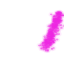

generated brushstroke
critic pred:  0.00032896510674618185 (true=0)


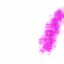

---
epoch 8/10  76/196 complete!
loss: 0.37805259227752686
real brushstroke
critic pred: 0.9864720106124878 (true=1)


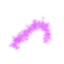

generated brushstroke
critic pred:  0.00047317903954535723 (true=0)


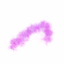

---
epoch 8/10  101/196 complete!
loss: 0.3743193745613098
real brushstroke
critic pred: 0.948225200176239 (true=1)


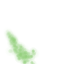

generated brushstroke
critic pred:  0.001470165210776031 (true=0)


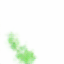

---
epoch 8/10  126/196 complete!
loss: 0.3703673481941223
real brushstroke
critic pred: 0.9715397953987122 (true=1)


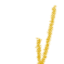

generated brushstroke
critic pred:  0.17645758390426636 (true=0)


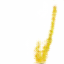

---
epoch 8/10  151/196 complete!
loss: 0.3667428493499756
real brushstroke
critic pred: 0.9988625049591064 (true=1)


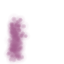

generated brushstroke
critic pred:  0.000312760123051703 (true=0)


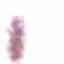

---
epoch 8/10  176/196 complete!
loss: 0.36297306418418884
real brushstroke
critic pred: 0.9999589920043945 (true=1)


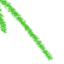

generated brushstroke
critic pred:  6.304989074124023e-05 (true=0)


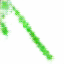

---
epoch 9/10  1/196 complete!
loss: 0.35983920097351074
real brushstroke
critic pred: 0.6534783840179443 (true=1)


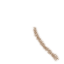

generated brushstroke
critic pred:  0.07046481221914291 (true=0)


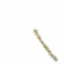

---
epoch 9/10  26/196 complete!
loss: 0.35608673095703125
real brushstroke
critic pred: 0.9986687898635864 (true=1)


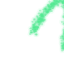

generated brushstroke
critic pred:  0.00010983486572513357 (true=0)


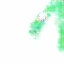

---
epoch 9/10  51/196 complete!
loss: 0.35370612144470215
real brushstroke
critic pred: 0.9998001456260681 (true=1)


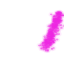

generated brushstroke
critic pred:  0.0007529053254984319 (true=0)


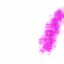

---
epoch 9/10  76/196 complete!
loss: 0.35017701983451843
real brushstroke
critic pred: 0.9999445676803589 (true=1)


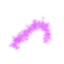

generated brushstroke
critic pred:  8.514896035194397e-05 (true=0)


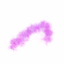

---
epoch 9/10  101/196 complete!
loss: 0.34662267565727234
real brushstroke
critic pred: 0.9989157915115356 (true=1)


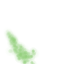

generated brushstroke
critic pred:  0.0017505267169326544 (true=0)


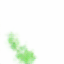

---
epoch 9/10  126/196 complete!
loss: 0.3432055115699768
real brushstroke
critic pred: 0.9284679889678955 (true=1)


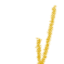

generated brushstroke
critic pred:  0.0009076547576114535 (true=0)


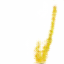

---
epoch 9/10  151/196 complete!
loss: 0.33992812037467957
real brushstroke
critic pred: 0.982955813407898 (true=1)


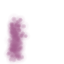

generated brushstroke
critic pred:  1.6736850739107467e-05 (true=0)


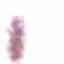

---
epoch 9/10  176/196 complete!
loss: 0.3415868878364563
real brushstroke
critic pred: 0.626450777053833 (true=1)


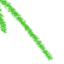

generated brushstroke
critic pred:  0.3558410406112671 (true=0)


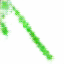

---
epoch 10/10  1/196 complete!
loss: 0.34175339341163635
real brushstroke
critic pred: 0.4630289375782013 (true=1)


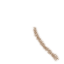

generated brushstroke
critic pred:  0.12871231138706207 (true=0)


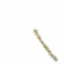

---
epoch 10/10  26/196 complete!
loss: 0.34045273065567017
real brushstroke
critic pred: 0.9469939470291138 (true=1)


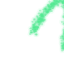

generated brushstroke
critic pred:  0.001288265804760158 (true=0)


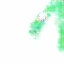

---
epoch 10/10  51/196 complete!
loss: 0.3388168513774872
real brushstroke
critic pred: 0.8741251826286316 (true=1)


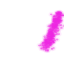

generated brushstroke
critic pred:  0.0030268821865320206 (true=0)


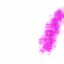

---
epoch 10/10  76/196 complete!
loss: 0.3366195559501648
real brushstroke
critic pred: 0.9886595010757446 (true=1)


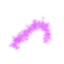

generated brushstroke
critic pred:  0.00038305690395645797 (true=0)


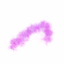

---
epoch 10/10  101/196 complete!
loss: 0.33434757590293884
real brushstroke
critic pred: 0.9576058387756348 (true=1)


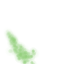

generated brushstroke
critic pred:  0.0007137908833101392 (true=0)


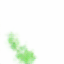

---
epoch 10/10  126/196 complete!
loss: 0.3321942687034607
real brushstroke
critic pred: 0.6414286494255066 (true=1)


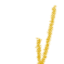

generated brushstroke
critic pred:  0.07486733049154282 (true=0)


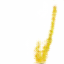

---
epoch 10/10  151/196 complete!
loss: 0.3299559950828552
real brushstroke
critic pred: 0.9913102388381958 (true=1)


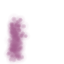

generated brushstroke
critic pred:  0.001793145784176886 (true=0)


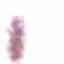

---
epoch 10/10  176/196 complete!
loss: 0.32819682359695435
real brushstroke
critic pred: 0.9997671246528625 (true=1)


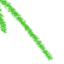

generated brushstroke
critic pred:  1.9249991964898072e-05 (true=0)


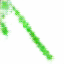

---
saving Critic ...
done.


In [0]:
root = 'models/'
model = 'neural_painter_x_'

if not os.path.isdir(root):
    os.mkdir(root)
    
critic_losses = []

print('training start!')


for epoch in range(params.train_epochs):

  losses = []

  for num_iter, (stroke, condition) in enumerate(dataloader):  
    condition = condition.cuda()
    stroke = torch.stack([strokes_tfms(s) for s in stroke]).cuda()

    # ground truths
    
    batch_size = stroke.shape[0]
    
    valid = torch.ones((batch_size, 1), dtype=torch.float, requires_grad=False).cuda()
    
    fake = torch.zeros((batch_size, 1), dtype=torch.float, requires_grad=False).cuda()

    # -----------------
    #  Train Critic
    # -----------------
    critic_optimizer.zero_grad()

    # computing the loss for true strokes
    critic_true_preds = torch.sigmoid(critic(stroke))
    critic_true_loss = critic_loss(critic_true_preds, valid)

    # computing the loss for generated (aka fake) strokes
    generated_stroke = generator(condition)
    critic_fake_preds = torch.sigmoid(critic(generated_stroke))
    critic_fake_loss = critic_loss(critic_fake_preds, fake)

    # taking the tarain loss as the average
    critic_train_loss = (critic_true_loss + critic_fake_loss) / 2.

    critic_train_loss.backward()
    critic_optimizer.step()

    critic_losses.append(critic_train_loss.data.item())

    if (num_iter % 25) == 0:
        print('epoch {}/{}  {}/{} complete!'.format((epoch + 1), 
                                                    params.train_epochs, 
                                                    (num_iter+1), 
                                                    len(dataloader)))
        print('loss: {}'.format(torch.mean(torch.FloatTensor(critic_losses))))
        # ---
        s = stroke[0].clone().cpu()
        print('real brushstroke')
        print('critic pred:', critic_true_preds[0].item(), '(true=1)')
        display(VF.to_pil_image(s))
        # ---
        g = generated_stroke[0].clone().cpu()
        print('generated brushstroke')
        print('critic pred: ', critic_fake_preds[0].item(), '(true=0)')
        display(VF.to_pil_image(g))
        print('---')
            
print('saving Critic ...')
torch.save(critic.state_dict(), root + model + 'non_adversarial_' + 'critic_param.pth')        
print('done.')

In [0]:
!ls models

neural_painter_x_non_adversarial_critic_param.pth
neural_painter_x_non_adversarial_generator_param.pth


### ~ Fin of this Part ~